# real_shape_optimization

> Fix isogonal modes and get real space vertices by minimizing metric energy under (soft?) tension constraint.


# to do:

- check for errors by writing a function that checks polygon intersection: is any point in any other polygon? use half-space check to do this. also function for self-intersection. see https://stackoverflow.com/questions/471962/how-do-i-efficiently-determine-if-a-polygon-is-convex-non-convex-or-complex/45372025#45372025

- wrap up the simulation time iteration with additional functions. clean up the energy function to make it more modular (i.e. enable switching out the function which calculates energy for each face).

- plotting function to color cells, or triangles by `dict`

In [ ]:
#| default_exp isogonal_face

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *

In [ ]:
#| export
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize

from tqdm.notebook import tqdm

from math import floor, ceil

import sys

from copy import deepcopy

from collections import Counter

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import autograd.numpy as anp  # Thinly-wrapped numpy
from autograd import grad as agrad

from scipy.sparse import csc_matrix

## Definition of the cell shape tensor

Now based off of the sides

In [ ]:
#| export

def polygon_area(pts):
    """area of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(pts[:,0]*anp.roll(pts[:,1], 1, axis=0) - anp.roll(pts[:,0], 1, axis=0)*pts[:,1])/2

def polygon_perimeter(pts):
    """perimeter of polygon assuming no self-intersection. pts.shape (n_vertices, 2)"""
    return anp.sum(anp.linalg.norm(pts-anp.roll(pts, 1, axis=0), axis=1))

def get_vertex_energy(pts, A0=1, P0=1, mod_shear=0, mod_bulk=1):
    """Get vertex style energy"""
    return mod_bulk*(polygon_area(pts)-A0)**2 + mod_shear*(polygon_perimeter(pts)-P0)**2

## Code for mesh energy

In [ ]:
#| export

# new plotting functions
@patch
def cellplot(self: HalfEdgeMesh, alpha=1):
    """Plot based on primal positions. Might be slow because loops over faces"""
    for fc in self.faces.values():
        for he in fc.hes:
            nghb = he.twin.face
            if nghb is not None:
                line = np.stack([fc.dual_coords, nghb.dual_coords])
                plt.plot(*line.T, c="k", alpha=alpha)

@patch
def labelplot(self: HalfEdgeMesh, vertex_labels=True, face_labels=True,
                     halfedge_labels=False, cell_labels=False):
    """for debugging purposes, a fct to plot a trimesh with labels attached"""
    if face_labels:
        for fc in self.faces.values():
            centroid = np.mean([he.vertices[0].coords for he in fc.hes], axis=0)
            plt.text(*centroid, str(fc._fid), color="k")
    if vertex_labels:
        for v in self.vertices.values():
            plt.text(*(v.coords+np.array([0,.05])), str(v._vid),
                     color="tab:blue", ha="center")
    if cell_labels:
        for v in self.vertices.values():
            nghbs = v.get_face_neighbors()
            if not (None in nghbs):
                center = np.mean([fc.dual_coords for fc in nghbs], axis=0)
                plt.text(*(center), str(v._vid),
                         color="tab:blue", ha="center")
    if halfedge_labels:
        for he in self.hes.values():
            if he.duplicate:
                centroid = np.mean([v.coords for v in he.vertices], axis=0)
                plt.text(*centroid, str(he._heid), color="tab:orange")

In [ ]:
#| export

@patch
def get_face_neighbors(self: Vertex):
    """Get face neighbors of vertex"""
    neighbors = []
    start_he = self.incident[0]
    he = start_he
    returned = False
    while not returned:
        neighbors.append(he.face)
        he = he.nxt.twin
        returned = (he == start_he)
    return neighbors

@patch
def set_centroid(self: HalfEdgeMesh):
    """Set dual positions to triangle centroid"""
    for fc in self.faces.values():
        vecs = []
        returned = False
        start_he = fc.hes[0]
        he = start_he
        while not returned:
            vecs.append(he.vertices[0].coords)
            he = he.nxt
            returned = (he == start_he)
        fc.dual_coords = np.mean(vecs, axis=0)

@patch
def transform_dual_vertices(self: HalfEdgeMesh, trafo: Union[Callable, NDArray[Shape["2, 2"], Float]]):
    for fc in self.faces.values():
        if isinstance(trafo, Callable):
            fc.dual_coords = trafo(fc.dual_coords)
        else:
            fc.dual_coords = trafo.dot(fc.dual_coords)

## Code for primal energy minimization

Need to ``serialize'' half edge mesh for rapid optimization

In [ ]:
#| export

@patch
def dual_vertices_to_initial_cond(self: HalfEdgeMesh):
    """Format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    dual_vertex_vector = np.stack([self.faces[key].dual_coords for key in face_keys]).T
    return np.hstack([dual_vertex_vector[0], dual_vertex_vector[1]])
       
@patch
def initial_cond_to_dual_vertices(self: HalfEdgeMesh, x0):
    """Reverse of format dual vertices for use in energy minimization."""
    face_keys = sorted(self.faces.keys())
    x, y = (x0[:int(len(x0)/2)], x0[int(len(x0)/2):])
    dual_vertex_vector = np.stack([x, y], axis=1)
    return {key: val for key, val in zip(face_keys, dual_vertex_vector)}


## Angle constraint energy

In [ ]:
#| export

@patch
def get_angle_deviation(self: HalfEdgeMesh):
    """Angle between primal and dual edges. For diagnostics"""
    angle_deviation = {}

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None):
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            primal_edge = he.face.dual_coords - he.twin.face.dual_coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = primal_edge / np.linalg.norm(primal_edge)        
            angle_deviation[he._heid] = np.dot(dual_edge, primal_edge)**2
    return angle_deviation

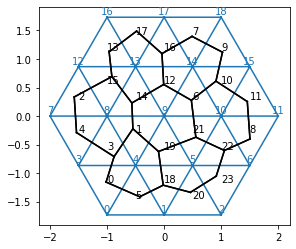

In [ ]:
# iterate over edges and ensure angle primal | dual = 0

mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.05))

mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=True)

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
fc = mesh.faces[19]
neighbors = [he.twin.face for he in fc.hes]
neighbors

[Face(fid=1, dual_coords=[-0.5, -0.2], hes=[3, 4, 5]),
 Face(fid=18, dual_coords=[-0.0, -1.2], hes=[56, 54, 55]),
 Face(fid=21, dual_coords=[0.6, -0.4], hes=[64, 65, 63])]

In [ ]:
sum(mesh.get_angle_deviation().values()) / 2

0.8868629463109334

## Energy function

In [ ]:
def get_primal_energy_fct(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2,
                          A0=sqrt(3)/2, P0=2*sqrt(3), energy="shape", vertex_reg=1e-2):
    """Get function to compute primal energy from primal vertices."""
    
    # stuff for the shape tensor energy
    primal_face_list = []
    rest_shapes = []
    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    
    for v in self.vertices.values():    # iterate around vertex.
        neighbors = v.get_face_neighbors()
        if not (None in neighbors):
            primal_face_list.append(anp.array([face_key_dict[fc._fid] for fc in neighbors])) # fc._fid
            rest_shapes.append(v.rest_shape)
    # cells might have differing #vertices, so don't make primal face list into array
    rest_shapes = anp.array(rest_shapes)
    n_faces = len(self.faces)

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)    
    center = anp.mean([fc.dual_coords for fc in self.faces.values()], axis=0)

    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        # shape energy - can be either vertex style or shape tensor based
        E_shape = 0
        for fc, rest in zip(primal_face_list, rest_shapes):
            pts = anp.stack([x[fc], y[fc]], axis=-1)
            if energy == "shape":
                delta = get_shape_tensor(pts, metric=False) - rest
                #delta = get_triangle_shape_tensor(pts, metric=False) - rest
                E_shape = E_shape + mod_shear*anp.sum(delta**2)+mod_bulk*anp.trace(delta)**2
                E_shape = E_shape + vertex_reg*(mod_bulk*(polygon_area(pts)-A0)**2
                                                + mod_shear*(polygon_perimeter(pts)-P0)**2)
            elif energy == "vertex":
                E_shape = E_shape+mod_bulk*(polygon_area(pts)-A0)**2+mod_shear*(polygon_perimeter(pts)-P0)**2
        # angle penalty
        pts = anp.stack([x, y], axis=-1)
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return E_shape + E_angle #+ E_trans
    
    return get_E, agrad(get_E)

In [ ]:
#| export

@patch
def get_primal_energy_fct_vertices(self: HalfEdgeMesh, mod_bulk=1, mod_shear=1e-3, angle_penalty=1e2,
                                   rest_shape=2*np.eye(2)):
    """Get function to compute primal energy from primal vertices."""
    
    # stuff for the shape tensor energy
    face_list = []
    rest_shapes = []
    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    face_key_dict[None] = None
    reference_edges = []
    
    # we want to also check the orientation of each edge. compare to connectors of tri centroids
    for fc in self.faces.values():
        neighbors = [he.twin.face for he in fc.hes]
        if not (None in neighbors):
            face_list.append(anp.array([face_key_dict[x._fid] for x in neighbors]
                                       +[face_key_dict[fc._fid]]))
            reference_edges.append([x.dual_coords-fc.dual_coords for x in neighbors])
    face_list = anp.array(face_list).T
    n_faces = len(self.faces)
    reference_edges = anp.array(reference_edges).transpose((1,0,2))
    reference_edges = (reference_edges.T / np.linalg.norm(reference_edges, axis=-1).T).T

    # stuff for the angle penalty
    e_dual = [] # dual vertices do not move during optimization, so collect the actual edges
    e_lst_primal = [] # for primal, collect the indices

    for he in self.hes.values():
        if (he.face is not None) and (he.twin.face is not None) and he.duplicate:
            dual_edge = he.vertices[1].coords-he.vertices[0].coords
            dual_edge = dual_edge / np.linalg.norm(dual_edge)
            primal_edge = [face_key_dict[fc._fid] for fc in [he.face, he.twin.face]]
            e_dual.append(dual_edge)
            e_lst_primal.append(primal_edge)
    e_dual = anp.array(e_dual)
    e_lst_primal = anp.array(e_lst_primal)    
    center = anp.mean([fc.dual_coords for fc in self.faces.values()], axis=0)
    
    def get_E(x0):
        x, y = (x0[:n_faces], x0[n_faces:])
        pts = anp.stack([x, y], axis=-1)
        # shape energy - can be either vertex style or shape tensor based
        E_shape = 0
        edges = anp.stack([pts[a]-pts[face_list[3]] for a in face_list[:3]])
        # get orientations
        orientation = anp.sign(anp.einsum("efi,efi->ef", edges, reference_edges))
        #oriented_edges = (edges.T*orientation.T/anp.linalg.norm(edges, axis=-1).T).T
        oriented_edges = (edges.T/anp.linalg.norm(edges, axis=-1).T).T
        tensors = 2*anp.einsum('efi,efj->fij', edges, oriented_edges) - rest_shape
        E_shape = (mod_shear*anp.sum(tensors**2)
                   + mod_bulk*anp.sum((tensors[:,0,0]+tensors[:,1,1])**2) )
        # angle penalty
        e_primal = pts[e_lst_primal[:,1]] - pts[e_lst_primal[:,0]]
        e_primal = (e_primal.T/anp.linalg.norm(e_primal, axis=-1)).T
        E_angle = angle_penalty * anp.mean(anp.einsum('ei,ei->e', e_primal, e_dual)**2)
        # break translation symmetry
        E_trans = 1/2*((anp.mean(x)-center[0])**2+(anp.mean(y)-center[0]))**2
        
        return E_shape + E_angle #+ E_trans
    
    return get_E, agrad(get_E)

## Minimization, constrained  - let's try to find a minimal example of bad behavior

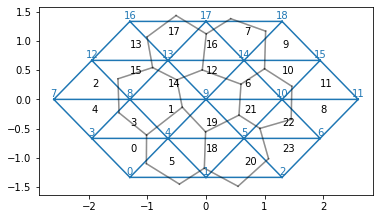

In [ ]:
mesh = get_tri_hemesh(noise=0, ny=5, nx=5)

#mesh.flip_edge(11)  # this creates an example of an edge with != 6 sides. e.g. 9
mesh.set_centroid()
mesh.set_rest_lengths() 
mesh.transform_dual_vertices(lambda x: x+np.random.normal(size=2, scale=.06)) #shear_mat(1.2)@x)
mesh.transform_vertices(shear_mat(1.3)) # 1.31almost 90 degree angles

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot()

plt.gca().set_aspect("equal", adjustable="box");

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_vertices(mod_bulk=1, mod_shear=.01, angle_penalty=10)
print(get_E(x0))

sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
print(sol["message"])
print(get_E(sol["x"]))

5.91210261023471
Optimization terminated successfully.
6.455355717293819e-08


In [ ]:
new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
for key, val in mesh.faces.items():
    val.dual_coords = new_coord_dict[key]

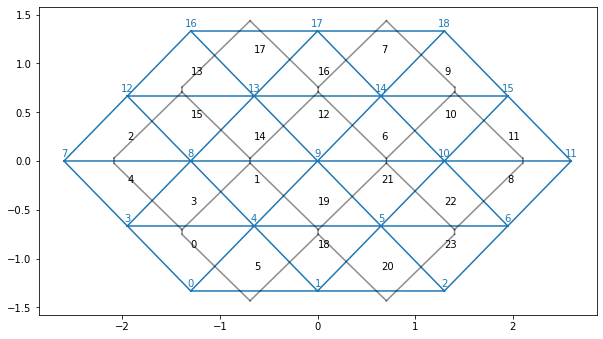

In [ ]:
# completely correct - but can have problem at boundary if there was an edge flip!
# in this case, ever self-intersection can occur.

# actuall;y it already does here!

fig = plt.figure(figsize=(10, 10))

mesh.cellplot(alpha=.25)
mesh.triplot()
mesh.labelplot() # halfedge_labels=True

#pts = np.stack([fc.dual_coords for fc in mesh.vertices[10].get_face_neighbors()])
#plt.scatter(*pts.T, c="r")

plt.gca().set_aspect("equal", adjustable="box");

## Full simulation, as example

Now we still need to compute the primal edge lengths! indexed by `_heid`

In [ ]:
#| export

@patch
def get_primal_edge_lens(self: HalfEdgeMesh):
    return {he._heid: np.linalg.norm(he.face.dual_coords-he.twin.face.dual_coords)
            for key, he in self.hes.items()
            if (he.face is not None) and (he.twin.face is not None) and he.duplicate} 
    
    return None

In [ ]:
#| export

def rotate_about_center(x, angle=pi/2):
    """Rotate pts about center. x.shape = (n_pts, 2)"""
    center = np.mean(x, axis=0)
    return (x-center)@rot_mat(angle)+np.mean(x, axis=0)

In [ ]:
primal_lengths = mesh.get_primal_edge_lens()
argmin = min(primal_lengths, key=primal_lengths.get)
argmin, primal_lengths[argmin]

(18, 3.6454554880219474e-07)

In [ ]:
def temp_plot(msh):
    msh.cellplot()
    msh.triplot()
    plt.xlim([-3, 3])
    plt.ylim([-2, 2])
    plt.gca().set_aspect("equal", adjustable="box")

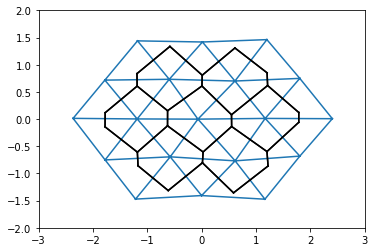

In [ ]:
mesh = get_tri_hemesh(noise=0, nx=5, ny=5)
mesh.set_centroid();
mesh.transform_vertices(lambda x: shear_mat(1.2)@x+np.random.normal(size=2, scale=.025))
# set origin
#mean = np.mean([v.coords for v in mesh.vertices.values()], axis=0)
#mesh.transform_vertices(lambda x: x-mean)

mesh.set_rest_lengths() 
mesh.set_voronoi()

temp_plot(mesh)

In [ ]:
x0 = mesh.dual_vertices_to_initial_cond()
get_E, jac = mesh.get_primal_energy_fct_vertices(mod_bulk=1, mod_shear=.01, angle_penalty=10)
print(get_E(x0))

sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
print(sol["message"])
print(get_E(sol["x"]))

2.4916579166541704
Optimization terminated successfully.
0.001789062326250102


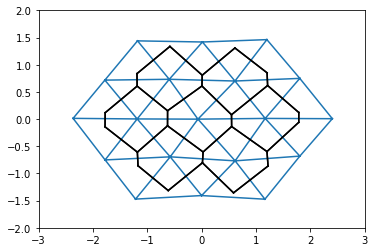

0
1
2
3
4
5


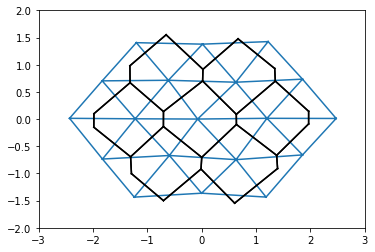

6
7
8
9
10


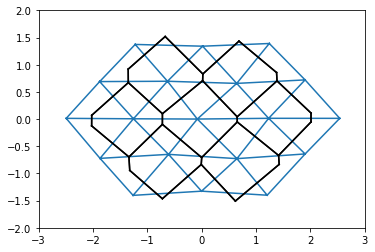

11
12
13
flip


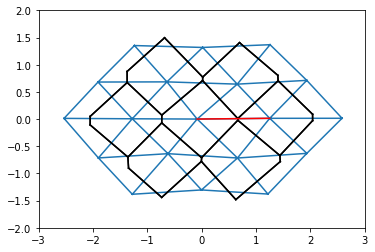

14
flip


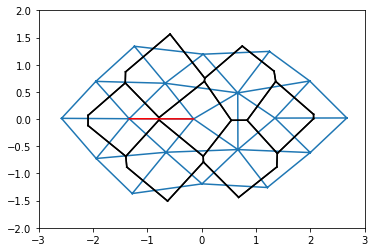

15


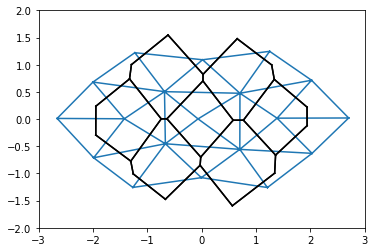

16
17
18
19
20


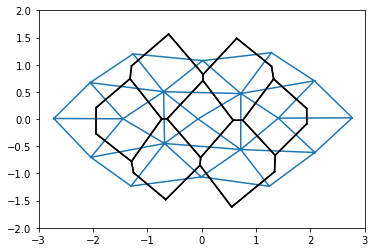

21
22
23
24
25


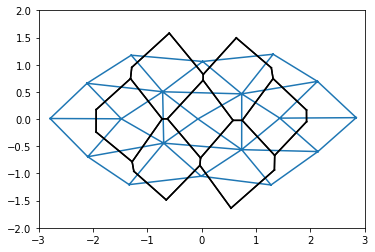

26
27
28
29
30


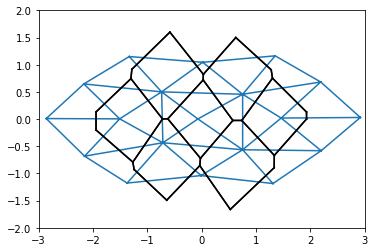

31
32
33
34
35
flip


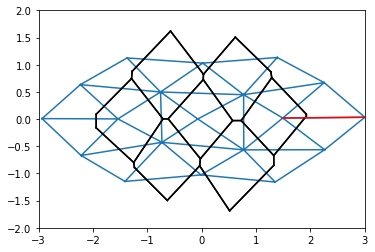

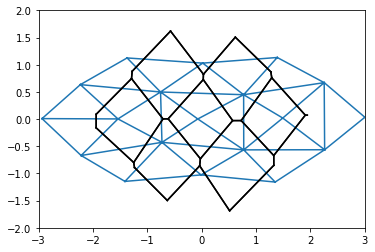

36
flip


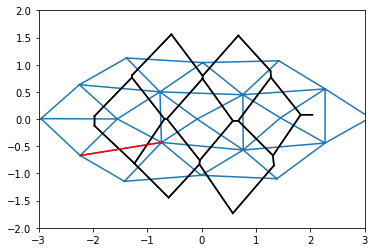

37
flip


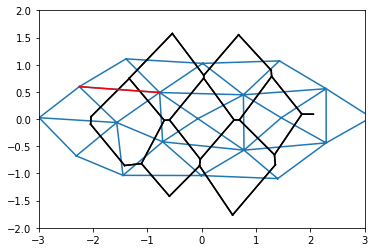

38
39
40


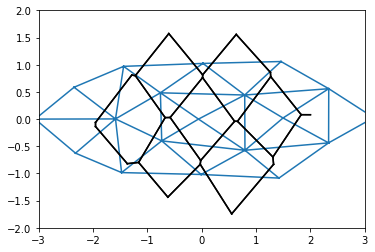

41
flip


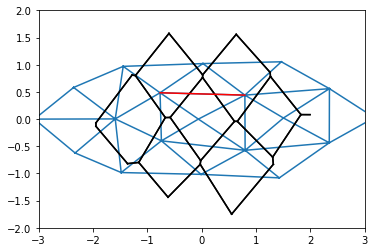

42
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


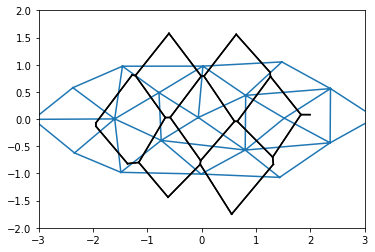

flip


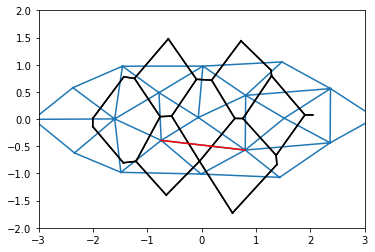

43
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


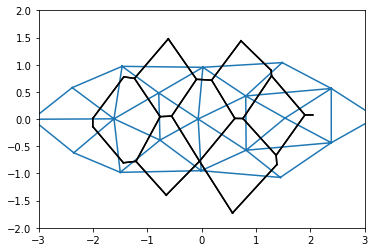

44
Cell shape optimization failed
Desired error not necessarily achieved due to precision loss.


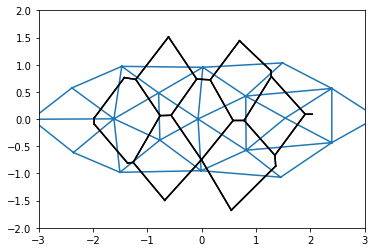

45


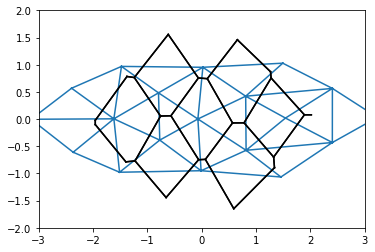

46
47
48
flip


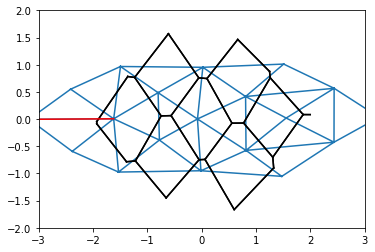

49
50


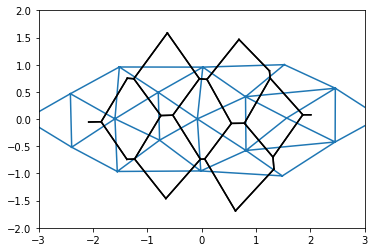

51
52
53
54


In [ ]:
#| notest
#%%time

## simulate

m = 2
k = .25
dt = .005

mod_shear = 0.01
mod_bulk = 1
angle_penalty = 10

A0, P0 = (sqrt(3)/2, 2*sqrt(3))

energy = "shape"

epsilon_l = .05

meshes = [mesh]
times = [0]

temp_plot(mesh)
plt.show()
plt.close()

T1_count = [0]

last_flipped_edge = -1

for i in range(55):
    print(i)
    
    # euler step
    for fc in mesh.faces.values():
        # collect edges
        Ts, Tps = (np.array([he.rest for he in fc.hes]), np.array([he.passive for he in fc.hes]))
        dT_dt, dTp_dt = excitable_dt_post(Ts, Tps, k=k, m=m)
        Ts += dt*dT_dt
        Tps += dt*dTp_dt
        for T, Tp, he in zip(Ts, Tps, fc.hes):
            he.rest = T
            he.passive = Tp
            
    # flatten triangulation
    get_E, grd = mesh.get_energy_fct()
    x0 = mesh.vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, method="BFGS", jac=grd, tol=1e-3)
    if sol["status"] !=0:
        print("Triangulation optimization failed")
        print(sol["message"])
        meshes.append(deepcopy(mesh))
        break
    new_coord_dict = mesh.initial_cond_to_vertices(sol["x"])
    for key, val in mesh.vertices.items():
        val.coords = new_coord_dict[key]
    mesh.set_rest_lengths()
    
    # primal optimization
    get_E, jac = mesh.get_primal_energy_fct_vertices(mod_bulk=mod_bulk, mod_shear=mod_shear,
                                                     angle_penalty=angle_penalty)
    x0 = mesh.dual_vertices_to_initial_cond()
    sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
    if sol["status"] !=0:
        print("Cell shape optimization failed")
        print(sol["message"])
        #fig = plt.figure(figsize=(15,15))
        temp_plot(mesh)
        plt.show()
        plt.close()
    new_coord_dict = mesh.initial_cond_to_dual_vertices(sol["x"])
    for key, val in mesh.faces.items():
        val.dual_coords = new_coord_dict[key]
    
    # check for intercalation
    primal_lengths = mesh.get_primal_edge_lens()
    argmin = min(primal_lengths, key=primal_lengths.get)
    if primal_lengths[argmin] < epsilon_l and argmin != last_flipped_edge:  
        try:
            # plot flip
            print("flip")
            temp_plot(mesh)
            he = mesh.hes[argmin]
            line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
            plt.plot(*line.T, c="r")
            plt.show()
            plt.close()
            # carry out flip
            mesh.flip_edge(argmin)
            mesh.reset_rest_passive_flip(he)
            f0, f1 = (he.face, he.twin.face)
            coords = np.stack([f0.dual_coords, f1.dual_coords])
            coords = rotate_about_center(coords, angle=pi/2)
            f0.dual_coords = coords[0]  
            f1.dual_coords = coords[1]
            last_flipped_edge = he._heid
            T1_count.append(T1_count[-1]+1)
        except ValueError:
            continue
    else:
        T1_count.append(T1_count[-1])
  
    # plot
    if i%5 == 0 and i>0:
        temp_plot(mesh)
        plt.show()
        plt.close()
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)

### notes:

- not too bad using non-metric oriented edges! Eventually still develops some self-intersection.

-> try regularizing using vertex energy!

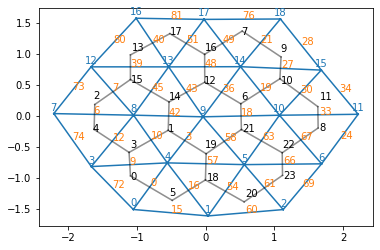

In [ ]:
t = 3

meshes[t].cellplot(alpha=.25)
meshes[t].triplot()
meshes[t].labelplot(halfedge_labels=True, vertex_labels=True, face_labels=True, cell_labels=False)



In [ ]:
x0 = meshes[t].dual_vertices_to_initial_cond()
get_E, jac = meshes[t].get_primal_energy_fct_vertices(mod_bulk=1, mod_shear=.01, angle_penalty=10)
print(get_E(x0))

sol = optimize.minimize(get_E, x0, jac=jac, method="BFGS", options={"gtol": 1e-3})
print(sol["message"])
print(get_E(sol["x"]))

0.2009797295118468
Optimization terminated successfully.
0.000695586279841244
